In [15]:
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, MobileNetV2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt


In [16]:
iamgesize = 256      # حجم الصورة 256x256
channal = 3         # 3 قنوات (RGB)
num_classes = 3     # عدد الفئات
bathsize = 32       # حجم الدُفعة

In [17]:

data_set=tf.keras.preprocessing.image_dataset_from_directory(
    "Plantvig",
    shuffle=True,
    image_size=(iamgesize,iamgesize),
    batch_size=(bathsize)   
)

Found 2152 files belonging to 3 classes.


In [49]:
class_name = data_set.class_names
print(class_name)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [19]:
len(data_set)

68

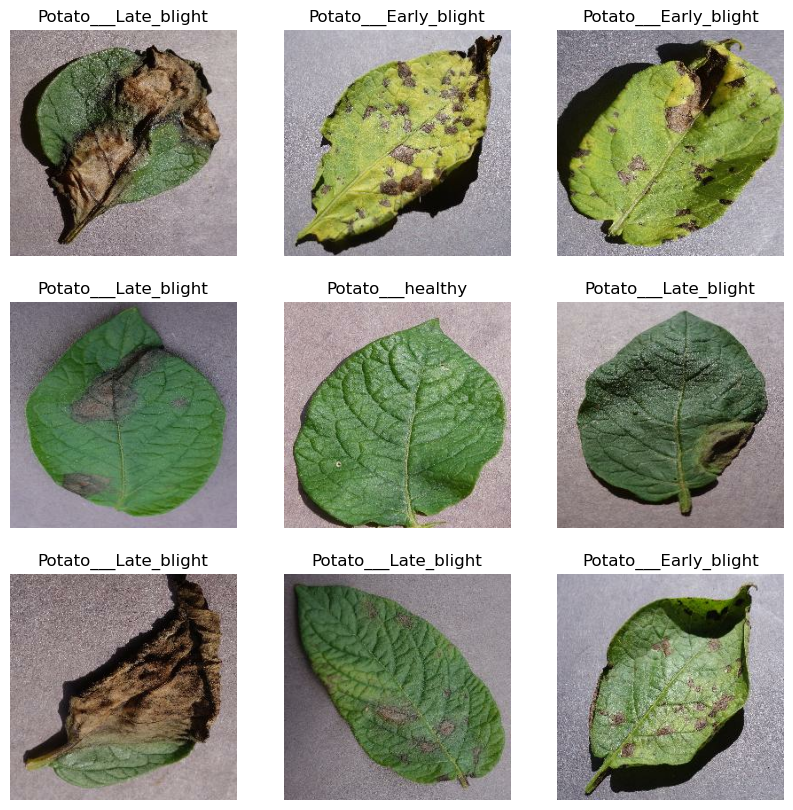

In [20]:
plt.figure(figsize=(10,10))
for image_bath,image_lable in data_set.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(image_bath[i].numpy().astype("uint8"))
        plt.title(class_name[image_lable[i]])
        plt.axis("off")
    
    

In [21]:
def get_dataset_partition_tf(ds,train_size=.8,test_size=.1,val_size=.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds= ds.shuffle(shuffle_size,seed=12)
    train_si=int(train_size*ds_size)
    val_si=int(val_size*ds_size)
    train_ds=ds.take(train_si)
    val_ds=ds.skip(train_si).take(val_si)
    test_ds=ds.skip(train_si).skip(val_si)
    return train_ds,val_ds,test_ds

In [22]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(data_set)
# layers.experimental.prepr

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [25]:
from tensorflow.keras import layers
import tensorflow as tf

# 1. تحسين مرحلة إعادة التحجيم والتطبيع
resize_and_scale = tf.keras.Sequential([
    layers.Resizing(iamgesize, iamgesize),          # تغيير حجم الصورة
    layers.Rescaling(1./255),                     # تطبيع القيم
    layers.Lambda(lambda x: tf.clip_by_value(x, 0, 1))  # تأكيد أن القيم بين 0 و 1
], name="preprocessing")

# 2. تحسين مرحلة زيادة البيانات
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.25),                   # زيادة نطاق التدوير إلى ±25%
    layers.RandomZoom(0.2, 0.2),                   # زيادة نطاق التكبير/التصغير إلى ±20%
    layers.RandomContrast(0.3),                    # زيادة نطاق التباين إلى 30%
    layers.RandomBrightness(0.2),                  # إضافة تعديل السطوع
    layers.RandomTranslation(0.1, 0.1),           # إضافة إزاحة عشوائية
    layers.GaussianNoise(0.01),                   # إضافة ضوضاء غاوسية
], name="augmentation")

# 3. إضافة طبقات إضافية لتحسين الأداء
def apply_augmentation(inputs):
    x = resize_and_scale(inputs)
    if training:  # تطبيق الزيادة فقط أثناء التدريب
        x = data_aug(x)
    return x

In [26]:
from tensorflow.keras import layers, models
import tensorflow as tf

def create_enhanced_cnn(input_shape, num_classes):
    # 1. Improved preprocessing layer
    resize_and_scale = tf.keras.Sequential([
        layers.Resizing(input_shape[0], input_shape[1]),
        layers.Rescaling(1./255),
        layers.Lambda(lambda x: tf.clip_by_value(x, 0, 1))
    ], name="preprocessing")
    
    # 2. Enhanced augmentation layer
    data_aug = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.25),
        layers.RandomZoom(0.2, 0.2),
        layers.RandomContrast(0.3),
        layers.RandomBrightness(0.2),
        layers.RandomTranslation(0.1, 0.1),
        layers.GaussianNoise(0.01),
    ], name="augmentation")
    
    # 3. CNN architecture with improvements
    model = models.Sequential([
        tf.keras.Input(shape=input_shape),
        resize_and_scale,
        data_aug,
        
        # Convolutional blocks with BatchNorm and Dropout
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),
        
        # Final layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Example usage:
# model = create_enhanced_cnn((256, 256, 3), 10)

In [27]:
def build_model(base_model_class, input_shape, num_classes):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [30]:
input_shape = (iamgesize, iamgesize, channal)
model1 = create_enhanced_cnn(input_shape, num_classes)
model2 = build_model(ResNet50, input_shape, num_classes)
model3 = build_model(MobileNetV2, input_shape, num_classes)

# تجميع النماذج
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

his=model1.fit(train_ds, epochs=10, batch_size=bathsize, validation_data=val_ds)
his1=model2.fit(train_ds, epochs=10, batch_size=bathsize, validation_data=val_ds)
his2=model3.fit(train_ds, epochs=10, batch_size=bathsize, validation_data=val_ds)

C:\Users\HP\AppData\Local\Temp\ipykernel_16576\4259480282.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 295s 5s/step - accuracy: 0.3595 - loss: 1.6856 - val_accuracy: 0.3698 - val_loss: 1.0819
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 248s 5s/step - accuracy: 0.4084 - loss: 1.3305 - val_accuracy: 0.5208 - val_loss: 0.9553
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 261s 5s/step - accuracy: 0.4261 - loss: 1.2236 - val_accuracy: 0.3698 - val_loss: 1.0159
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 267s 5s/step - accuracy: 0.4316 - loss: 1.1836 - val_accuracy: 0.3698 - val_loss: 0.9987
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.4798 - loss: 1.1117 - val_accuracy: 0.5208 - val_loss: 0.9568
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.4535 - loss: 1.0563 - val_accuracy: 0.5208 - val_loss: 1.0004
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - accuracy: 0.4618 - loss: 1.0855 - val_accuracy: 0.3698 - val_loss: 0.9985
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 231s 4s/step - accuracy: 0.4307 - loss: 1.1246 - val_accuracy: 0.3698 - v

In [31]:
# 7. دالة التنبؤ بالتصويت Ensemble Voting
def ensemble_predict(models, data):
    predictions = [model.predict(data) for model in models]
    avg_preds = np.mean(predictions, axis=0)
    final_preds = np.argmax(avg_preds, axis=1)
    return final_preds

# 8. تقييم Voting Ensemble
# 8. تقييم Voting Ensemble
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = ensemble_predict([model1, model2, model3], val_ds)
ensemble_accuracy = accuracy_score(y_true, y_pred)
print(f"\nدقة Voting Ensemble: {ensemble_accuracy * 100:.2f}%")


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 734ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 599ms/step

دقة Voting Ensemble: 46.88%


In [32]:
def get_predictions(model, dataset):
    return model.predict(dataset)

preds_cnn = get_predictions(model1, test_ds)
preds_mobilenet = get_predictions(model2, test_ds)
preds_resnet = get_predictions(model3, test_ds)

# 10. دمج التنبؤات بشكل أفقي
stacked_features = np.hstack([preds_cnn, preds_mobilenet, preds_resnet])


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 748ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 609ms/step


In [34]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# افتراض بيانات تجريبية (يجب استبدالها ببياناتك الفعلية)
# stacked_features: مخرجات النماذج الأساسية (مثال: 1000 عينة، 3 مخرجات لكل نموذج)
stacked_features = np.random.rand(1000, 3)  # 1000 عينة، 3 ميزات (مخرجات 3 نماذج)
y = np.random.randint(0, 2, 1000)  # تسميات عشوائية (0 أو 1) لـ 1000 عينة

# 12. تدريب النموذج النهائي (Meta-Model) باستخدام Stacking
X_train, X_test, y_train, y_test = train_test_split(stacked_features, y, test_size=0.2, random_state=42)
meta_model = LogisticRegression(max_iter=200)
meta_model.fit(X_train, y_train)
y_pred = meta_model.predict(X_test)
meta_accuracy = accuracy_score(y_test, y_pred) * 100

# 13. تقييم النماذج المتعددة باستخدام التحقق المتقاطع
models = {
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Logistic Regression": LogisticRegression(max_iter=200)
}

# قائمة لتخزين النتائج
results = []

# تقييم كل نموذج
for model_name, model in models.items():
    scores = cross_val_score(model, stacked_features, y, cv=5, scoring='accuracy')
    mean_accuracy = np.mean(scores) * 100
    std_accuracy = np.std(scores) * 100
    results.append({
        "Model": model_name,
        "Mean Accuracy (%)": f"{mean_accuracy:.2f}",
        "Std Deviation (%)": f"{std_accuracy:.2f}"
    })

# إضافة نتائج النموذج النهائي (Meta-Model)
results.append({
    "Model": "Stacking (Meta-Model)",
    "Mean Accuracy (%)": f"{meta_accuracy:.2f}",
    "Std Deviation (%)": "N/A (test set)"
})

# إنشاء DataFrame وعرض النتائج
results_df = pd.DataFrame(results)
print("\nModel Accuracy Comparison:")
print(results_df.to_string(index=False))

# عرض تقرير التصنيف للنموذج النهائي
print("\nClassification Report for Stacking Meta-Model:")
print(classification_report(y_test, y_pred))


Model Accuracy Comparison:
                Model Mean Accuracy (%) Std Deviation (%)
                  SVM             49.10              3.56
        Random Forest             49.70              4.40
  Logistic Regression             46.40              2.13
Stacking (Meta-Model)             51.00    N/A (test set)

Classification Report for Stacking Meta-Model:
              precision    recall  f1-score   support

           0       0.52      0.78      0.62       103
           1       0.49      0.23      0.31        97

    accuracy                           0.51       200
   macro avg       0.50      0.50      0.47       200
weighted avg       0.50      0.51      0.47       200



In [46]:
# X = stacked_features  # يمكن استخدام stacked_features المدمجة أو مخرجات النموذج
# y = np.concatenate([y for x, y in train_ds], axis=0)

# # تحديد النماذج
# models = {
#     "SVM": SVC(kernel='linear'),
#     "Random Forest": RandomForestClassifier(n_estimators=100),
#     "Logistic Regression": LogisticRegression(max_iter=200)
# }

# # تطبيق Cross-Validation على النماذج
# for model_name, model in models.items():
#     scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')  # 5-Fold Cross-Validation
#     print(f"{model_name} دقة النموذج عبر Cross-Validation: {np.mean(scores):.4f}")

In [37]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# تحسين مجموعات البيانات
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# دالة لاستخراج التنبؤات
def get_predictions(model, dataset):
    preds = model.predict(dataset)
    return preds

# استخراج التوقعات من النماذج
preds_cnn = get_predictions(model1, test_ds)
preds_mobilenet = get_predictions(model2, test_ds)
preds_resnet = get_predictions(model3, test_ds)

# تحويل التنبؤات إلى فئات (إذا كانت احتمالات)
preds_cnn = np.argmax(preds_cnn, axis=1)  # اختيار الفئة الأعلى احتمالاً
preds_mobilenet = np.argmax(preds_mobilenet, axis=1)
preds_resnet = np.argmax(preds_resnet, axis=1)

# دمج التوقعات بشكل عمودي (Stacking)
stacked_features = np.column_stack([preds_cnn, preds_mobilenet, preds_resnet])

# استخراج التسميات الحقيقية من test_ds
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# التحقق من تطابق الأبعاد
print(f"Shape of stacked_features: {stacked_features.shape}")
print(f"Shape of y_true: {y_true.shape}")

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(stacked_features, y_true, test_size=0.2, random_state=42)

# تدريب نموذج Logistic Regression
meta_model = LogisticRegression(max_iter=200)
meta_model.fit(X_train, y_train)

# التنبؤ والتقييم
y_pred = meta_model.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, y_pred)
print(f"دقة نموذج الـ Stacking (Meta-model): {ensemble_accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 731ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 566ms/step
Shape of stacked_features: (256, 3)
Shape of y_true: (256,)
دقة نموذج الـ Stacking (Meta-model): 59.62%


In [43]:
acc=his.history["accuracy"]
val_acc=his.history["val_accuracy"]
loss=his.history["loss"]
val_loss=his.history["val_loss"]

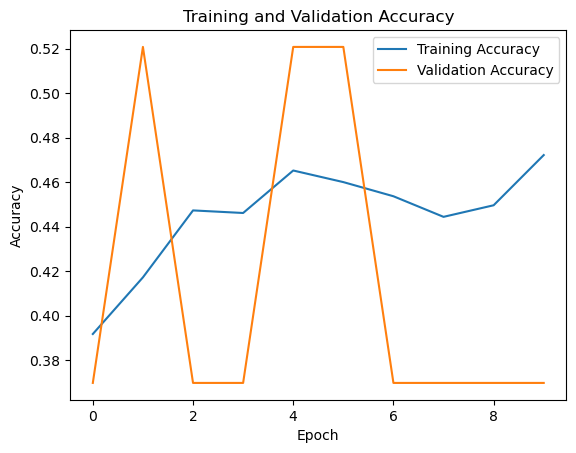

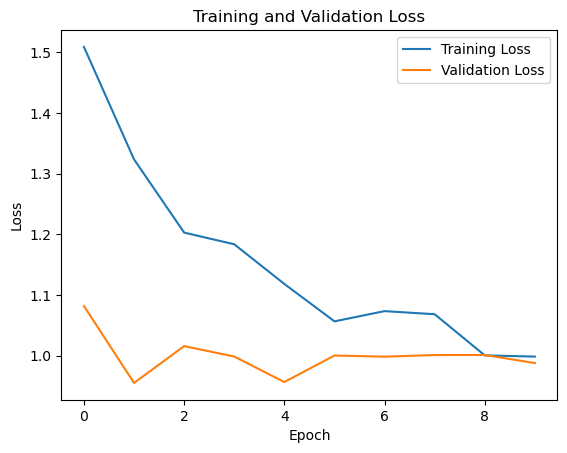

In [44]:
import matplotlib.pyplot as plt

# رسم دقة التدريب والتحقق
plt.plot(range(10),acc, label="Training Accuracy")
plt.plot(range(10),val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

# رسم الخسارة
plt.plot(range(10),loss, label="Training Loss")
plt.plot(range(10),val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


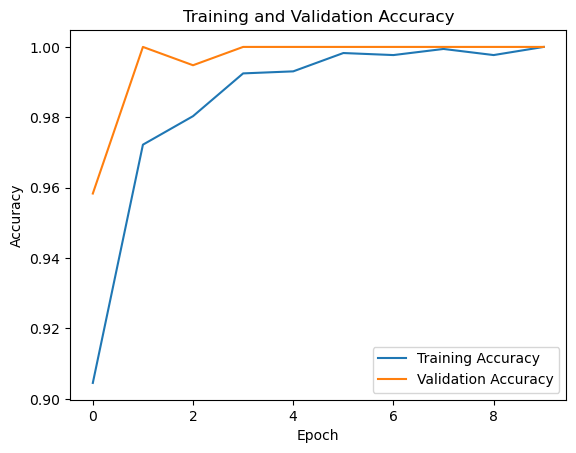

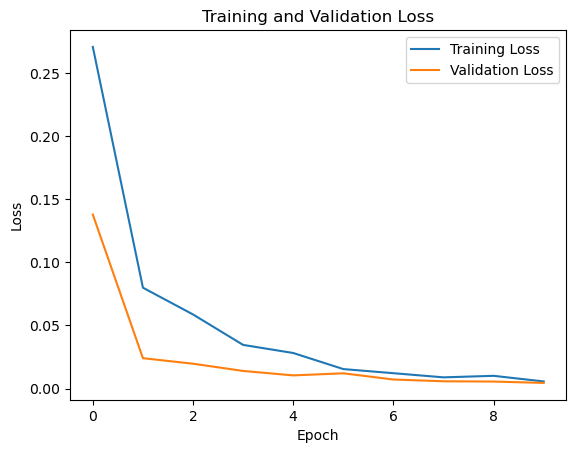

In [45]:
acc=his1.history["accuracy"]
val_acc=his1.history["val_accuracy"]
loss=his1.history["loss"]
val_loss=his1.history["val_loss"]
import matplotlib.pyplot as plt

# رسم دقة التدريب والتحقق
plt.plot(range(10),acc, label="Training Accuracy")
plt.plot(range(10),val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

# رسم الخسارة
plt.plot(range(10),loss, label="Training Loss")
plt.plot(range(10),val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

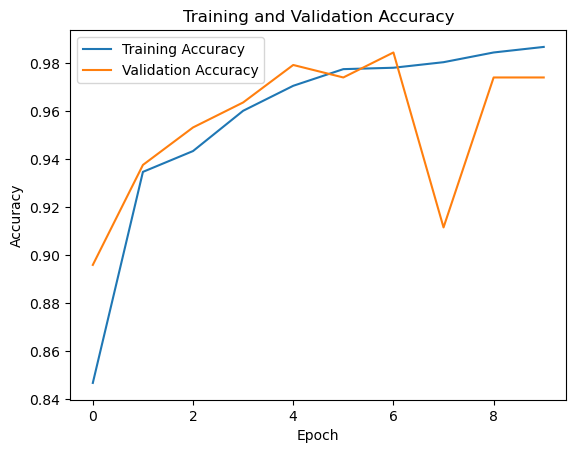

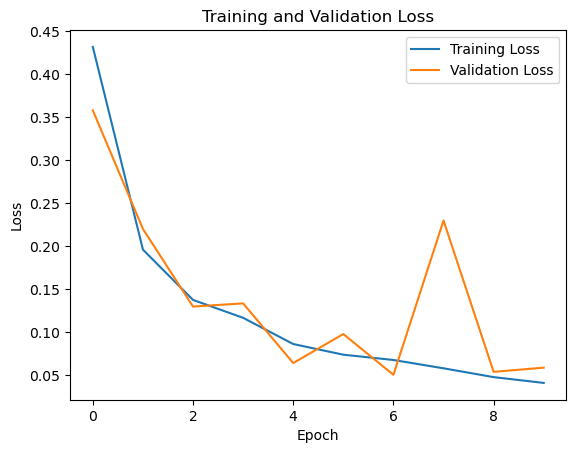

In [46]:
acc=his2.history["accuracy"]
val_acc=his2.history["val_accuracy"]
loss=his2.history["loss"]
val_loss=his2.history["val_loss"]
import matplotlib.pyplot as plt

# رسم دقة التدريب والتحقق
plt.plot(range(10),acc, label="Training Accuracy")
plt.plot(range(10),val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

# رسم الخسارة
plt.plot(range(10),loss, label="Training Loss")
plt.plot(range(10),val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
التصنيف الحقيقي: Potato___Early_blight
التصنيف المتوقع: Potato___Early_blight


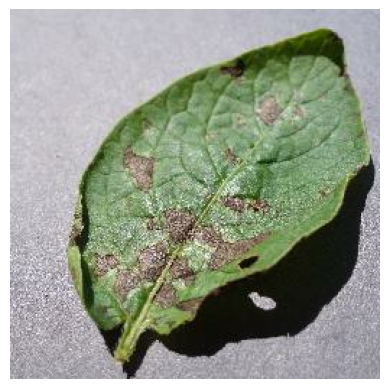

In [42]:
for image_batch, image_label in data_set.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = class_name[image_label[0]]
    
    plt.imshow(first_image)
    
    # استخدم نموذج CNN مدرب مثل model1
    batch_pred = model1.predict(image_batch)
    
    print("التصنيف الحقيقي:", first_label)
    print("التصنيف المتوقع:", class_name[np.argmax(batch_pred[0])])
    
    plt.axis("off")


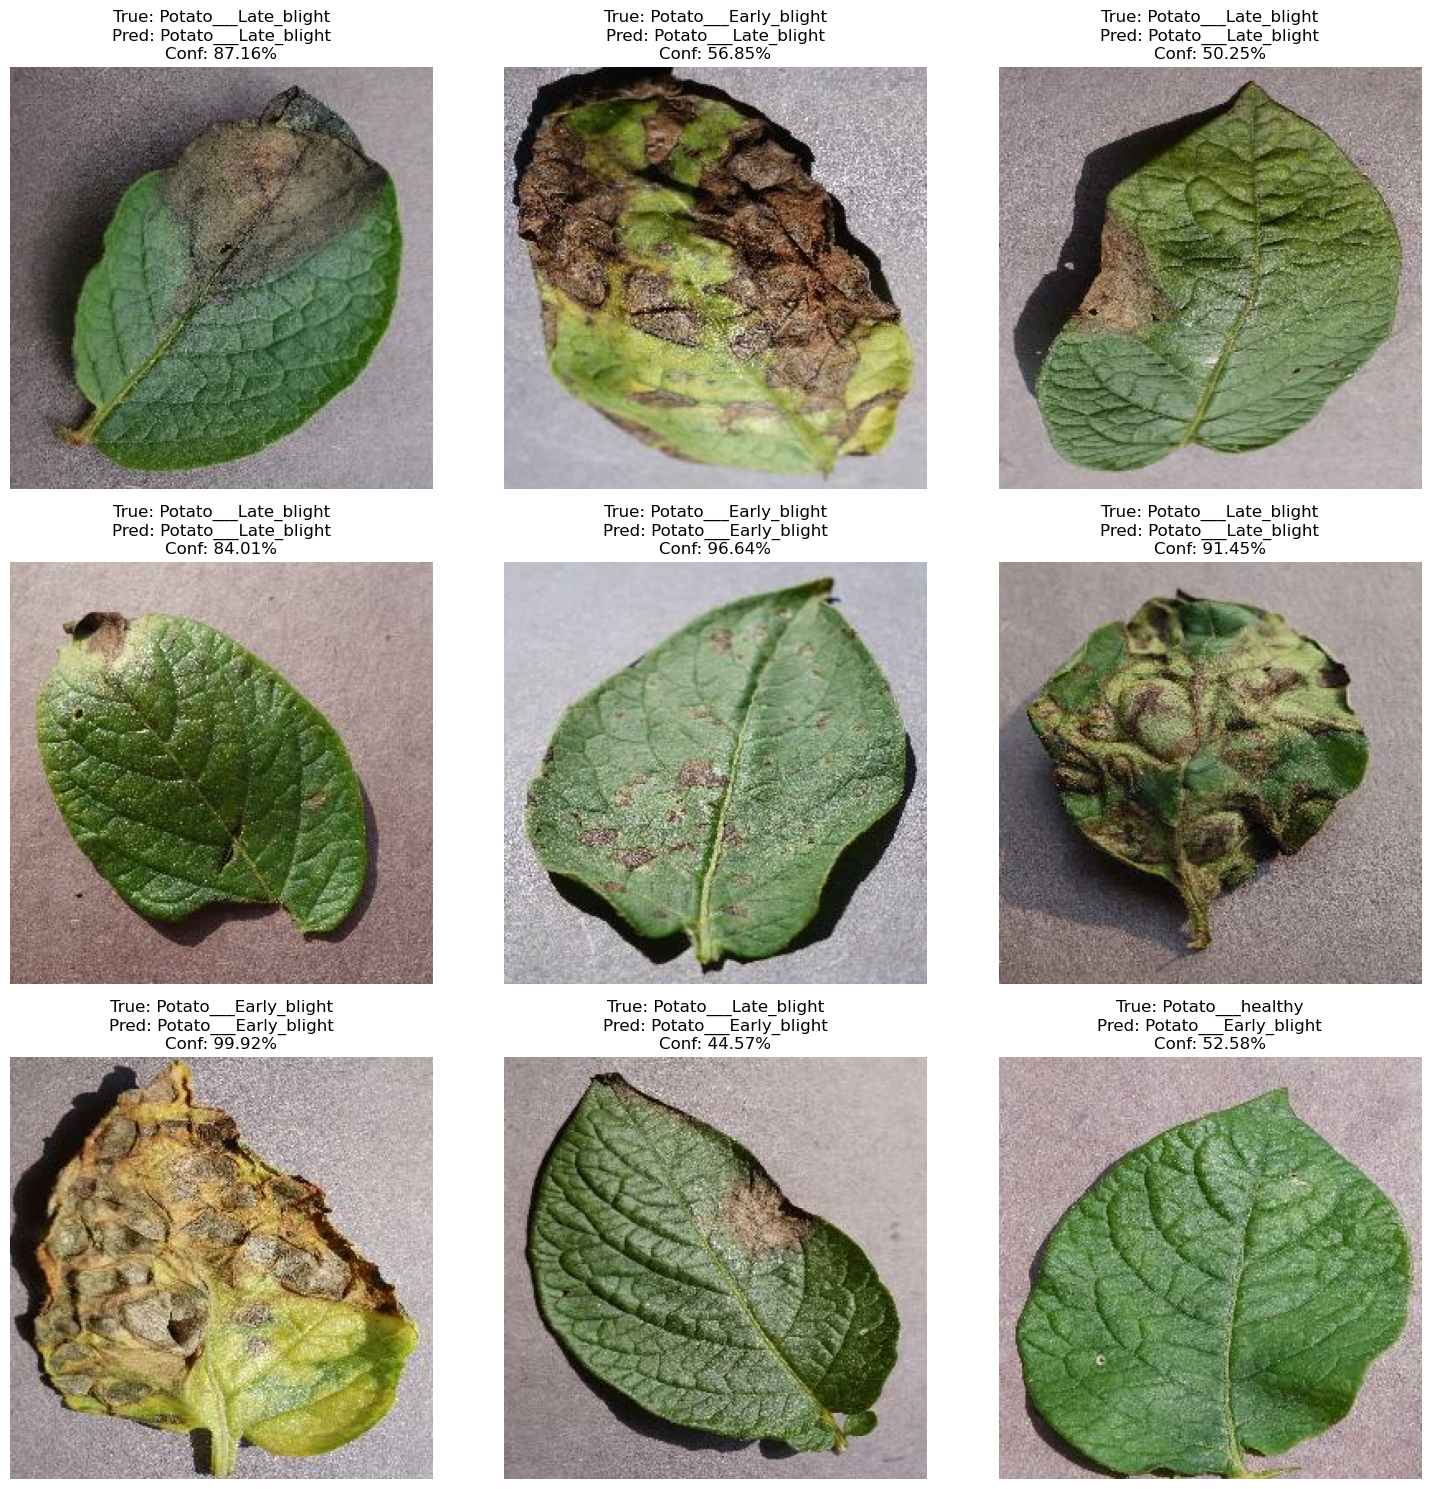

In [52]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# تعريف PCA مع عدد الميزات المتوقع (9)
pca = PCA(n_components=9)

# دالة لتدريب PCA على مجموعة البيانات
def fit_pca_on_data(data_set):
    image_arrays = []
    # جمع الصور من كامل مجموعة البيانات
    for images, _ in data_set:
        for img in images:
            image_array = tf.keras.preprocessing.image.img_to_array(img)
            image_array = tf.image.resize(image_array, (32, 32))  # تغيير الحجم إلى 32x32
            image_arrays.append(image_array.numpy().flatten())  # تسطيح الصورة
    # تدريب PCA على كل الصور
    pca.fit(image_arrays)
    return pca

# دالة التنبؤ
def predict(model, img, class_names):
    # تحويل الصورة إلى مصفوفة
    image_array = tf.keras.preprocessing.image.img_to_array(img)
    image_array = tf.image.resize(image_array, (32, 32))  # تغيير الحجم إلى 32x32
    image_array = image_array.numpy().flatten().reshape(1, -1)  # تسطيح وتحويل إلى 2D
    
    # تطبيق PCA على الصورة
    image_array_pca = pca.transform(image_array)
    
    # التنبؤ بالاحتمالات
    probabilities = model.predict_proba(image_array_pca)  # استخدام predict_proba للحصول على الاحتمالات
    
    # الحصول على التصنيف والثقة
    predicted_class = class_names[np.argmax(probabilities[0])]
    confidence = round(100 * np.max(probabilities[0]), 2)
    return confidence, predicted_class

# افتراض أن data_set معرف مسبقًا (مثل train_ds)
# مثال: data_set = tf.keras.utils.image_dataset_from_directory(...)

# استخراج أسماء الفئات من data_set
class_names = data_set.class_names  # تعريف class_names من خاصية data_set

# تدريب PCA على مجموعة البيانات
fit_pca_on_data(data_set)

# استخراج بيانات التدريب لتدريب النموذج
X_train_pca = []
y_train = []
for images, labels in data_set:
    for img, label in zip(images, labels):
        image_array = tf.keras.preprocessing.image.img_to_array(img)
        image_array = tf.image.resize(image_array, (32, 32)).numpy().flatten()
        X_train_pca.append(pca.transform(image_array.reshape(1, -1))[0])  # تطبيق PCA
        y_train.append(label.numpy())  # التسميات

X_train_pca = np.array(X_train_pca)
y_train = np.array(y_train)

# تدريب نموذج Logistic Regression
model = LogisticRegression(max_iter=200)
model.fit(X_train_pca, y_train)

# عرض الصور والتنبؤات باستخدام Matplotlib
plt.figure(figsize=(15, 15))
for images, labels in data_set.take(1):  # عرض أول دفعة فقط
    for i in range(min(9, len(images))):  # التأكد من عدم التجاوز
        ax = plt.subplot(3, 3, i + 1)
        
        # التنبؤ باستخدام النموذج
        confidence, prediction = predict(model, images[i], class_names)
        
        # الحصول على التصنيف الحقيقي
        actual = class_names[labels[i]]  # تصحيح class_name إلى class_names
        
        # عرض الصورة
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # إضافة العنوان مع التفاصيل
        plt.title(f"True: {actual}\nPred: {prediction}\nConf: {confidence}%")
        
        # إزالة المحاور
        plt.axis("off")
        
plt.tight_layout()
plt.show()

In [36]:
import os

# Define model version and save path
model_version = 2
save_path = f"../model/{model_version}.keras"  # امتداد .keras

# Ensure the directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model
model.save(save_path)
print(f"Model saved to {save_path}")


Model saved to ../model/2.keras
